In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

#### Simulation setup

In [2]:
sim = rw.Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**2
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
energy = 3*10**15 # eV
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions
        

source = rw.PointSourceOriented(energy, source_pos, nr_particles, pitch_angle, phi)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  100
energy:  3000000000000000  eV
source tpye: PointSourceOriented
pitch angle:  0.955393232541696
phi:  0.0


#### Propagator

In [4]:
nr_steps = 2*10**5
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
rms = 1 # Gaus
magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
#propagator.set_pitch_angle_const(False)
sim.add_propagator(propagator)
sim.propagator.get_description()

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

propagation tpye: AnisotropicPropagator
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle sp

#### Observer

In [5]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
sim.add_observer(observer)
sim.observer.get_description()

number steps:  169
Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: TimeEvolutionObserverLog
spheres:  [-1.]
steps [0:10]:  [ 1  2  3  4  5  6  7  8  9 10]
steps [-11:-1]:  [108304 115155 122439 130185 138420 147176 156486 166385 176910 188101]
nr steps:  169
substeps:  [False False  True]
all_steps:  False


In [6]:
%time sim.run_simulation()
sim.save_data('data/data_sim')

CPU times: user 46.9 s, sys: 28 ms, total: 46.9 s
Wall time: 46.9 s


## Analyze statistics


init statistics plotting class


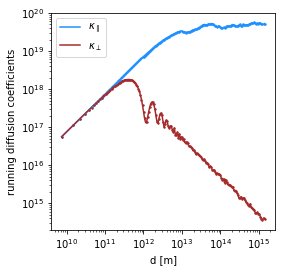

In [7]:
df = pd.read_pickle("data/data_sim.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
sta = rw.Statistics(df_time_evolution_observer)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

In [25]:
rwp_d = df_kappas['d'].tolist()
rwp_kappa_perp = df_kappas['kappa_perp'].tolist()
rwp_kappa_para = df_kappas['kappa_para'].tolist()

In [26]:
### load crpropa data
crp_d = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_d.npy')
crp_kappa_perp = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_kappa_perp.npy')
crp_kappa_para = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_kappa_para.npy')

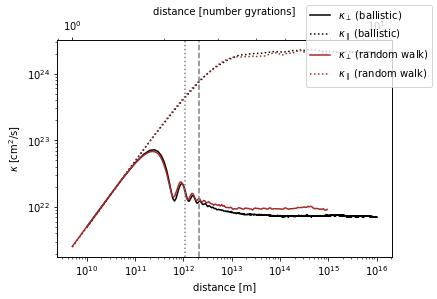

In [27]:
fig, ax1 = plt.subplots()

ax1.plot(crp_d, np.array(crp_kappa_perp)*10**4, label='$\kappa_\perp$ (ballistic)', color='k')
ax1.plot(crp_d, np.array(crp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (ballistic)', color='k')
ax1.plot(rwp_d, np.array(rwp_kappa_perp)*10**4, label='$\kappa_\perp$ (random walk)', color='brown')
ax1.plot(rwp_d, np.array(rwp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (random walk)', color='brown')

ax1.set_xlabel('distance [m]')
ax1.axvline(x=mfp[1], c='grey', ls=':')
ax1.axvline(x=mfp[2], c='grey', ls='--')
ax1.loglog()
ax1.set_ylabel('$\kappa$ [cm$^2$/s]')

ax2 = ax1.twiny()
#ax2.scatter(np.array([rwp_d[0], rwp_d[-1]]) / (2 * np.pi * gyro_radius), np.ones(2)*kappa_perp_mean*10**4, s=0.0001)
ax2.set_xlabel('distance [number gyrations]')
ax2.loglog()

fig.legend()
plt.show()
#plt.savefig('kappas_bB05.pdf')